# BAX Emittance Minimization (LCLS-II)
In this notebook, we hope to demonstrate Bayesian Algorithm Execution (BAX) in Xopt as a means of minimizing the emittance at LCLS-II. BAX is a generalization of Bayesian Optimization that seeks to acquire observations that provide our model with maximal information about our property of interest. In this example, our property of interest is the minimal emittance and its location in tuning-parameter-space. See https://arxiv.org/pdf/2209.04587.pdf for details.

# Imports

In [2]:
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

# append path to parent directory (SLAC_Xopt)
import sys
sys.path.append("../../../")

import matplotlib.pyplot as plt
# import os    
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import pandas as pd
import torch

from xopt import Xopt
from xopt.vocs import VOCS
from xopt.generators.bayesian.bax_generator import BaxGenerator

from xopt.evaluator import Evaluator

from emitopt.utils import (post_path_emit_squared,
                           compute_emits,
                           get_meas_scan_inputs_from_tuning_configs,
                           get_valid_emittance_samples)
from emitopt.sampling import draw_product_kernel_post_paths
from emitopt.algorithms import ScipyMinimizeEmittance

from scripts.evaluate_function.screen_image import measure_beamsize, measure_background

import time
import numpy as np
import random

# General settings

In [3]:
# general settings
N_OBS_INIT = 3 # number of random initial observations
N_ITER = 25 # number of iterations for Xopt to perform

# BAX algorithm settings
N_SAMPLES = 10
N_STEPS_MEASUREMENT_PARAM = 3
N_STEPS_EXE_PATHS = 10

# measurement settings
VAR_FILE = '../variables.csv'
TUNING_VARIABLES = ["SOLN:GUNB:212:BCTRL"
                    "SOLN:GUNB:823:BCTRL"
                    "QUAD:GUNB:212:1:BCTRL"
                    "QUAD:GUNB:212:2:BCTRL"
                    "QUAD:GUNB:823:1:BCTRL"
                    "QUAD:GUNB:823:2:BCTRL"]
SCAN_VARIABLE = "QUAD:HTR:120:BCTRL" # assign measurement parameter
SCREEN_NAME = "OTRS:HTR:330"
QUAD_LENGTH = 1.0 # m
DRIFT_LENGTH = 1.0 # m
BEAM_ENERGY = 0.135 # GeV
SCALE_FACTOR = 1.0 # multiplicative factor to convert from measurement quad PV units to geometric focusing strength
ROI = None
THRESHOLD = 3000

# random seeds for reproducibility
rand_seed = 2
torch.manual_seed(rand_seed)
np.random.seed(rand_seed) # only(?) affects initial random observations through Xopt 
random.seed(rand_seed)

# Evaluator

In [ ]:
# define function to measure the total size on OTR4
def eval_beamsize(input_dict):
    results = measure_beamsize(input_dict)
    results["S_x_mm"] = results["Sx"] * 1e3
    results["S_y_mm"] = results["Sy"] * 1e3

    #add total beam size
    results["total_size"] = np.sqrt(results["Sx"]**2 + results["Sy"]**2)
    results["total_size_squared"] = (results["Sx"]**2 + results["Sy"]**2)
    return results

## (Optional) Measure background image

In [ ]:
MEASURE_BACKGROUND = True
if MEASURE_BACKGROUND:
    measure_background(SCREEN_NAME)
    BACKGROUND_FILE = f"{SCREEN_NAME}_background.npy".replace(":","_")
    
    # verify background image
    plt.imshow(np.load(BACKGROUND_FILE))
    
else:
    BACKGROUND_FILE = None

## Constants and Constraints

In [3]:
# constants
measurement_options = {
    "screen": SCREEN_NAME,
    "background": BACKGROUND_FILE,
    "threshold": THRESHOLD,
    "roi": ROI,
    "bb_half_width": 3.0, # half width of the bounding box in terms of std
    "visualize": True
}

# constraints
image_constraints = {
    "bb_penalty": ["LESS_THAN", 0.0],
    "log10_total_intensity": ["GREATER_THAN", 4]
}

## Variables

In [4]:
from scripts.variables import read_variables_from_csv, write_variables_to_csv

# fetch variables
VARIABLE_RANGES = read_variables_from_csv(VAR_FILE)
VARIABLE_RANGES

{'SOLN:GUNB:212:BCTRL': [0.042826, 0.044574],
 'SOLN:GUNB:823:BCTRL': [0.0245, 0.0255],
 'QUAD:GUNB:212:1:BCTRL': [-0.005, 0.005],
 'QUAD:GUNB:212:2:BCTRL': [-0.005, 0.005],
 'QUAD:GUNB:823:1:BCTRL': [-0.005, 0.005],
 'QUAD:GUNB:823:2:BCTRL': [-0.005, 0.005],
 'QUAD:HTR:120:BCTRL': [-4.48035, 4.479]}

# VOCS

In [86]:
# construct vocs
vocs = VOCS(
    variables = {ele: VARIABLE_RANGES[ele] for ele in TUNING_VARIABLES},
    constants = measurement_options,
    constraints = image_constraints,
    objectives = {"total_size_squared": 'MINIMIZE'}
)

# get dimension index for measurement device
MEAS_DIM = list(vocs.variables).index(SCAN_VARIABLE)
print('MEAS_DIM =', MEAS_DIM)

# BAX algorithm

In [ ]:
from emitopt.algorithms import ScipyMinimizeEmittance
algo_kwargs = {
        'scale_factor': SCALE_FACTOR,
        'q_len': QUAD_LENGTH,
        'distance': DRIFT_LENGTH,
        'n_samples': N_SAMPLES,
        'meas_dim': MEAS_DIM,
        'n_steps_measurement_param': N_STEPS_MEASUREMENT_PARAM,
        'n_steps_exe_paths':  N_STEPS_EXE_PATHS}
algo = ScipyMinimizeEmittance(**algo_kwargs)

# Product kernel model constructor

In [6]:
from gpytorch.kernels import MaternKernel, PolynomialKernel, ScaleKernel
from gpytorch.priors.torch_priors import GammaPrior

from xopt.generators.bayesian.models.standard import StandardModelConstructor
from xopt.generators.bayesian.bax_generator import BaxGenerator

# make list of all non-measurement quad dimension indeces
tuning_dims = list(range(vocs.n_variables))
tuning_dims.remove(MEAS_DIM)

# prepare product kernel (Matern x Quadratic)
covar_module = MaternKernel(active_dims=tuning_dims, lengthscale_prior=GammaPrior(3.0, 6.0)) * PolynomialKernel(
    power=2, active_dims=[MEAS_DIM]
)
scaled_covar_module = ScaleKernel(covar_module, outputscale_prior=GammaPrior(2.0, 0.15))   

# prepare options for Xopt generator
covar_module_dict = {"total_size_squared": scaled_covar_module}

model_constructor = StandardModelConstructor(covar_modules=covar_module_dict)

# Numerical optimizer (for acquisition function)

In [ ]:
from xopt.numerical_optimizer import LBFGSOptimizer
numerical_optimizer = LBFGSOptimizer(
                                    n_raw_samples=20,
                                    n_restarts=20,
                                    max_iter=100)

# Initialize Xopt Optimizer

In [4]:
#construct BAX generator
generator = BaxGenerator(vocs=vocs, 
                         model_constructor=model_constructor, 
                         numerical_optimizer=numerical_optimizer,
                         algorithm=algo)
#construct evaluator
evaluator = Evaluator(function=eval_beamsize)

#construct Xopt optimizer
optimizer = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

# call X.random_evaluate() to generate random initial points and evaluate on test_func
optimizer.random_evaluate(N_OBS_INIT)

NameError: name 'vocs' is not defined

# Optimize

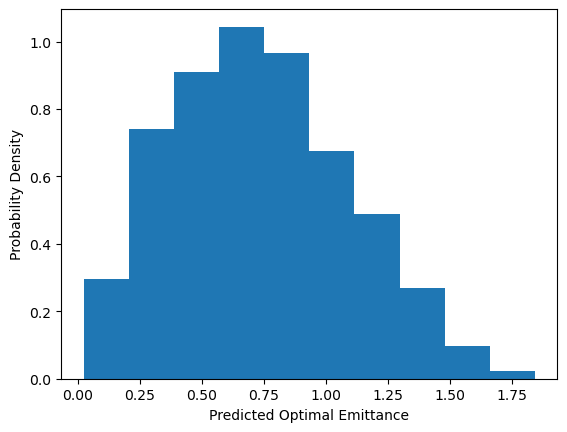

sample validity rate: tensor([0.1265])
Iteration: 1 / 25
This iteration took: 5.562591314315796 seconds.

Iteration: 2 / 25
This iteration took: 2.520416498184204 seconds.

Iteration: 3 / 25
Scipy failed to find at least 3 physically valid solutions.
This iteration took: 1.3702845573425293 seconds.

Iteration: 4 / 25
Scipy failed to find at least 3 physically valid solutions.
This iteration took: 1.1636667251586914 seconds.

Iteration: 5 / 25
Scipy failed to find at least 3 physically valid solutions.
This iteration took: 0.8794224262237549 seconds.



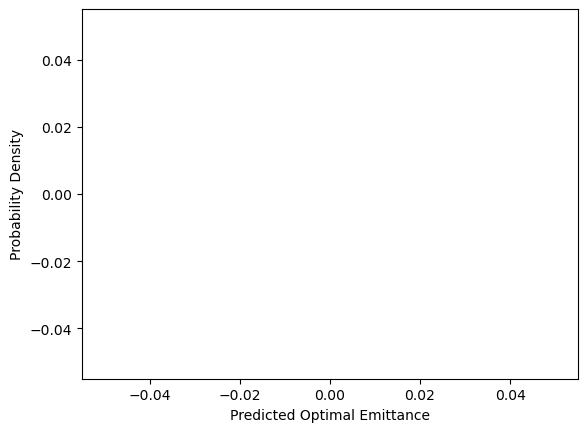

sample validity rate: tensor([0.])
Iteration: 6 / 25
This iteration took: 9.02418327331543 seconds.

Iteration: 7 / 25
This iteration took: 5.739625692367554 seconds.

Iteration: 8 / 25
This iteration took: 7.810025930404663 seconds.

Iteration: 9 / 25
This iteration took: 7.092968702316284 seconds.

Iteration: 10 / 25
This iteration took: 7.638046741485596 seconds.



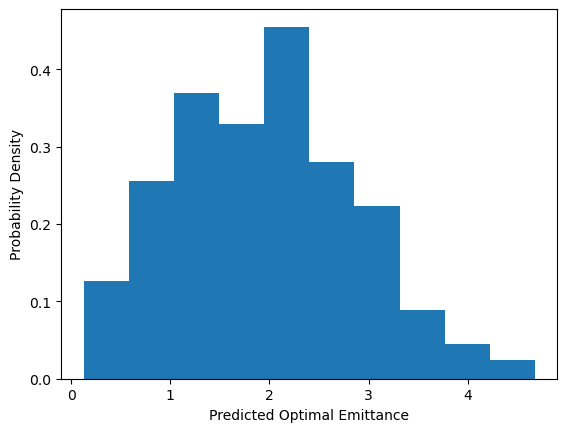

sample validity rate: tensor([0.0541])
Iteration: 11 / 25
This iteration took: 4.861624717712402 seconds.

Iteration: 12 / 25
This iteration took: 4.941431999206543 seconds.

Iteration: 13 / 25
This iteration took: 5.091416358947754 seconds.

Iteration: 14 / 25
This iteration took: 5.190473556518555 seconds.

Iteration: 15 / 25
This iteration took: 9.738130331039429 seconds.



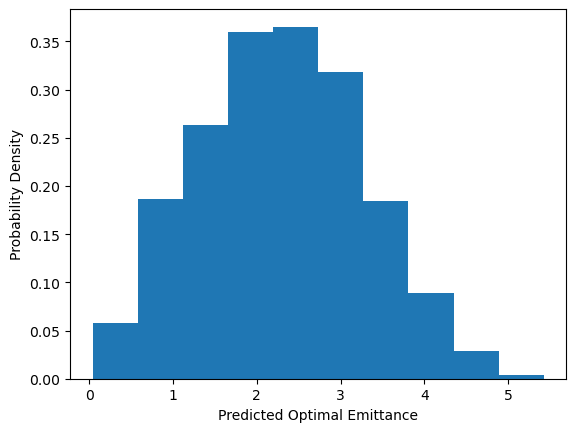

sample validity rate: tensor([0.3082])
Iteration: 16 / 25
This iteration took: 8.988223552703857 seconds.

Iteration: 17 / 25
This iteration took: 6.433661699295044 seconds.

Iteration: 18 / 25
This iteration took: 15.973903179168701 seconds.

Iteration: 19 / 25
This iteration took: 13.13979172706604 seconds.

Iteration: 20 / 25
This iteration took: 7.521343946456909 seconds.



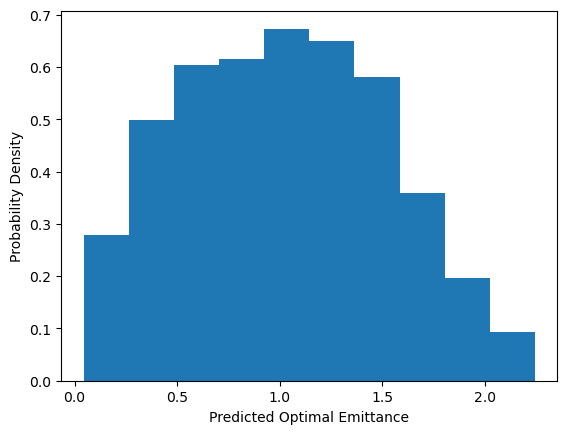

sample validity rate: tensor([0.0392])
Iteration: 21 / 25
This iteration took: 3.9619295597076416 seconds.

Iteration: 22 / 25
This iteration took: 7.403325796127319 seconds.

Iteration: 23 / 25
This iteration took: 8.652895450592041 seconds.

Iteration: 24 / 25
This iteration took: 8.727697849273682 seconds.

Iteration: 25 / 25
This iteration took: 19.1471049785614 seconds.



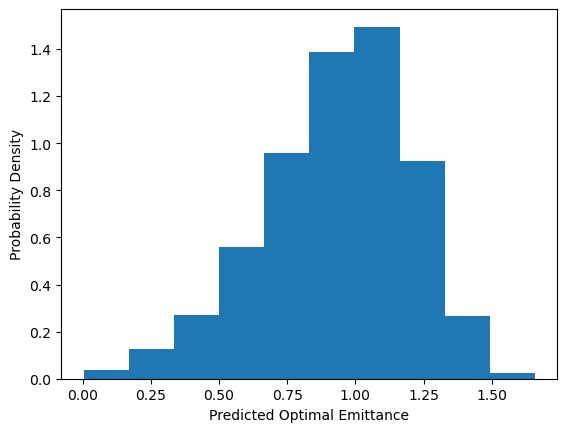

sample validity rate: tensor([0.9466])


In [10]:
#get initial emittance prediction at ground truth optimum
beam_size_model = optimizer.generator.train_model().models[0]


#get mean-predicted optimal tuning config and eval predicted emits at this location in tuning parameter space
algo = optimizer.generator.algorithm
X_tuned, emits_at_target_valid, emits_sq_at_target, is_valid, svr = algo.mean_output(beam_size_model, 
                                                                                     torch.tensor(vocs.bounds), 
                                                                                     num_restarts=10)


plt.hist(emits_at_target_valid.flatten().cpu(), density=True)
plt.xlabel('Predicted Optimal Emittance')
plt.ylabel('Probability Density')
plt.show()
print('sample validity rate:', svr)

for i in range(1, n_iter+1):

    print('Iteration:', i, '/', n_iter)

    start = time.time()

    # call X.step() to generate a point and evaluate on test_func
    optimizer.step()    

    
    # get beam size (objective) model
    beam_size_model = optimizer.generator.model.models[0]

    #get mean-predicted optimal tuning config and eval predicted emits at this location in tuning parameter space
    algo = optimizer.generator.algorithm
    X_tuned, emits_at_target_valid, emits_sq_at_target, is_valid, svr = algo.mean_output(beam_size_model,
                                                                                         torch.tensor(vocs.bounds),
                                                                                         num_restarts=10)
    
    end = time.time()
    print('This iteration took:', end-start, 'seconds.\n')

    if i % 5 == 0:
        plt.hist(emits_at_target_valid.flatten().cpu(), density=True)
        plt.xlabel('Predicted Optimal Emittance')
        plt.ylabel('Probability Density')
        plt.show()
        print('sample validity rate:', svr)